# Data from single trajectory
Generate learning data (Euler truncation errors) from a single trajectory of the Van der Pol equation.

In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import scipy.integrate
import h5py

np.random.seed(42)

In [3]:
ro_L = 9.970639504998557e+02
P_inf = 1.0e+5
p_v = 3.166775638952003e+03
sigma = 0.071977583160056
R_E = 10.0/1.0e6
gam = 1.4
c_L = 1.497251785455527e+03
mu_L = 8.902125058209557e-04
theta = 0.0
P_A1 = 1e5
P_A2 = 0.0
f = 20e3 #20 kHz
f2 = 0.0

class Keller():
    '''The ODE function of the Keller-Miksis equation'''
    
    def __init__(self):
        super().__init__()
        
        C = np.zeros(13)
        twr = 1.0/(R_E*f)
        C[0] = (P_inf - p_v + 2*sigma/R_E)/ro_L*twr*twr
        C[1] = (1-3*gam)/(ro_L*c_L)*(P_inf - p_v + 2*sigma/R_E)*twr
        C[2] = (P_inf - p_v)/ro_L * twr*twr
        C[3] = 2*sigma/(ro_L*R_E) *twr*twr
        C[4] = 4*mu_L/(ro_L*R_E*R_E) / f
        C[5] = P_A1/ro_L * twr*twr
        C[6] = P_A2/ro_L *twr*twr
        C[7] = R_E * 2*math.pi*f * P_A1/(ro_L*c_L) * twr*twr
        C[8] = R_E * 2*math.pi*f * P_A2/(ro_L*c_L) * twr*twr
        C[9] = R_E*f / c_L
        C[10] = 3*gam
        C[11] = f2 / f
        C[12] = theta
        self.C = C
    
    def ode(self, t, x):
        '''ODE function'''
        C = self.C
        dxdt = np.ones(x.shape)
        rx0 = 1.0 / x[0];
        
        N = (C[0]+C[1]*x[1])*pow(rx0,C[10]) - C[2]*(1.0+C[9]*x[1]) -C[3]*rx0 -C[4]*x[1]*rx0 -\
        (1.5 - 0.5*C[9]*x[1])*x[1]*x[1] -\
        (C[5]*np.sin(2.0*math.pi*t) + C[6]*np.sin(2.0*math.pi*C[11]*t + C[12])) * (1.0+C[9]*x[1])-\
        x[0] * (C[7]*np.cos(2.0*math.pi*t) + C[8]*np.cos(2.0*math.pi*C[11]*t+C[12]) );
        
        D = x[0] - C[9]*x[0]*x[1] + C[4]*C[9];
                
        dxdt[0] = x[1]
        dxdt[1] = N / D
        return dxdt

In [18]:
end = 3
keller = Keller()
sol = scipy.integrate.solve_ivp(keller.ode, [0, end], [ 1, 0], rtol=1e-10, atol=1e-10)

dydt = keller.ode(sol.t, sol.y)

In [ ]:
sol.y.shape

## Plot

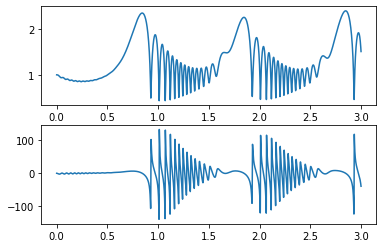

In [20]:
plt.figure(num="pl1")
plt.subplot(2,1,1)
plt.plot(sol.t,sol.y[0])
plt.subplot(2,1,2)
plt.plot(sol.t,sol.y[1])
plt.show()

## Save data

In [22]:
if not os.path.isdir('data'):
    os.mkdir('data')
np.savetxt('data/keller_data_3_7k.txt', np.column_stack((sol.t, np.array(sol.y).T, dydt.T)))

## Convert data and save in hdf5 format

In [25]:
def euler_truncation_error(arr, output_size): 
    
    #arr: [t y1 y2 ... dy1 dy2...]
    dt = arr[1:,0] - arr[:-1,0]
    X = np.column_stack(( np.mod(arr[1:,0], 1), dt, arr[:-1,1:output_size+1])) #t dt y1 y2 ...
    dt_m = np.empty((len(dt), output_size))
    dt_m[:,0] = dt
    for n in range(1, output_size):
        dt_m[:,n] = dt
    Y = np.reciprocal(dt_m*dt_m)*(arr[1:,1:output_size+1] - arr[:-1,1:output_size+1] - dt_m*arr[:-1, output_size+1:])
    return X,Y

In [ ]:
#Script for saving data in format X = [t%1 dt y1 y2 ...], Y = [e1 e2 ...]

path_to_hdf = 'data/keller_data_3_7k.hdf5'
path_to_txt = 'data/keller_data_3_7k.txt'

number_of_equations = 2

arr = np.loadtxt(path_to_txt, dtype=np.float64, delimiter=' ') #[t y1 y2 ... dy1 dy2...]

l = arr.shape[0]
b = 1
n = 7500
sum = 0
for i in range(b,n):
    sum = sum + l - i - 1

with h5py.File(path_to_hdf, 'a') as f:
    f.create_dataset(
        str('X'),
        (sum, (arr.shape[1]-1)/2+2),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 9
        )
    f.create_dataset(
        str('Y'),
        (sum, (arr.shape[1]-1)/2 ),
        dtype   = np.float64,
        compression     = 'gzip',
        compression_opts= 9
        )
    begin = 0
    end = l-1
    X = f['X']
    Y = f['Y']
    x,y = euler_truncation_error(np.copy(arr[:][0::b]), number_of_equations)
    X[begin:end,:] = x
    Y[begin:end,:] = y
    for i in range(b+1,n):
        if i%1000==1:
            print(i)
        for j in range(i):
            x,y = euler_truncation_error(np.copy(arr[:][j::i]), number_of_equations)
            begin = end
            end = begin+x.shape[0]
            X[begin:end,:] = x
            Y[begin:end,:] = y
        

In [5]:
#save decreased amount of data
data_size = 4000000
path_to_hdf = 'data/keller_data_3_7k.hdf5'
new_store_path = 'data/keller_data_7k_4M.hdf5'
with h5py.File(path_to_hdf, 'r') as f:
    X = np.empty(f["X"].shape)
    f["X"].read_direct(X) 
    Y = np.empty(f["Y"].shape)
    f["Y"].read_direct(Y)
    mask = np.zeros(X.shape[0], dtype=bool)
    mask[:data_size] = np.ones(data_size)
    np.random.shuffle(mask)
    
      
    X_small = X[mask,:]
    Y_small = Y[mask,:]
    with h5py.File(new_store_path, "w") as nf:
        nf.create_dataset(
            str('X'),
            data    = X_small,
            dtype   = np.float64,
            compression     = 'gzip',
            compression_opts= 9
        )
        nf.create_dataset(
            str('Y'),
            data    = Y_small,
            dtype   = np.float64,
            compression     = 'gzip',
            compression_opts= 9
        )
print("Ready")